In [3]:
import pandas as pd
import numpy as np
from typing import Dict, Text
import random
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import implicit
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scipy.sparse as sparse
from sklearn import metrics
pd.set_option('display.max_columns', 70)
import tensorflow_datasets as tfds
from collections import OrderedDict

## Background:

Knowing which home listings to recommend to a guest could provide huge business value to Airbnb.Therefore, ​we would like to train a recommender model that can predict which listings specific user is likely to book​. Thedataset provided here contains a random sample of our 7-day search log from two markets: Rio de Janeiro and SaoPauloEvery time a user conducts a search they are shown certain number of listings that are available for the searchedlocation, dates and search filters. Given the search results, the user can conduct one or more action on a specific listing:impress (no action), click (which takes user to listing page), contact host (to inquire about listing) and finally book.

## Data Description
- Each row in the dataset is one of the listings that is a result of a search conducted by a user (identified withid_search)
- Each row has a label that tells us what is the ultimate action performed on the listing: impression, click, contacthost or book. Keep in mind that we use the latest action as label. Therefore, if label is contact host, it means thatbefore that user also did an impression and click. Or if the label is book, the user also did impression and clickon the listing and may have contacted the host (if ds_contact is present) or may have just directly bookedwithout contacting the host.
- Listings are uniquely defined using id_listing field in the dataset.
- Searcher (Booker) is uniquely defined using id_user field in the datasetFeatures:​ The features can be categorized into the following groups:
- Query Features​: (they start with query_* in the dataset) These are features related to user’s search query(location, check-in & check-out dates and filters such as number of guests, etc)
- Listing Features​: (they start with listing_* in the dataset) These are various attributes of the listings (such asprice, review count, review rating, location, etc.)

## Your assignment:​ 
You have 72 hours to play with the data and tackle the problem using machine learning to build arecommender system for a specific searcher. The requirements are:
- Build a model that will be able to recommend the most relevant (bookable) listings to users for the given searchparameters.
- You can formulate the problem as a ​ranking problem​ or a ​top-K recommendation problem​ as long as you canjustify your choice and test the recommendation model using applicable metics.
- Start with a baseline model that is more than a random guess and see how much you can improve from there.
- Show how you evaluate and improve your model performance. Explain your choice of evaluation technique. Sincethis is a recommendation/ranking problem that we are addressing, use at least one metric that tests how well yourank or recommend at top-K
- Using the provided dataset, derive additional features to demonstrate your data sense and creativity.
- Note that no user personalization features are provided in the dataset. Leverage id_user within the search datato derive at least one feature that captures  users’ historical preferences for use in your recommender.
- What consequences does your model have on new listings? Are they recommended enough? How would youchange the recommendation model such that you optimize not only for bookings in general but for bookings ofnew listings as well> Demonstrate your approach and evaluate it using a metric of choice.
- Identify opportunities of using your model in Airbnb’s marketplace. For what purposes could it be used?
- Please submit one document and provide code and a writeup (e.g. in R Markdown or iPython Notebook).
- In order to minimize unconscious bias in our review process, please don't include your name or any identifyingpersonal details in your submission.

In [4]:
df = pd.read_csv('takehome_data_algo.csv')
df.shape

(177588, 48)

In [16]:
df.head()

,id_search,label,id_user,id_listing,ds_search,ds_book,ds_contact,query_market,query_checkin,query_checkout,query_num_guests,query_num_children,query_num_infants,query_radius,query_price_max,query_price_min,query_center_lat,query_center_lng,listing_is_new,listing_total_price,listing_instant_bookable,listing_lat,listing_lng,listing_review_rating,listing_review_count,listing_property_type,listing_room_type,listing_num_beds,listing_num_bedrooms,listing_num_bathrooms,listing_person_capacity,listing_has_pro_pictures,listing_num_recent_reservations,listing_location_rating,listing_cleanliness_rating,listing_checkin_rating,listing_value_rating,listing_communication_rating,listing_accuracy_rating,listing_num_books_90day,listing_occupancy_rate,listing_monthly_discount,listing_weekly_discount,listing_cleaning_fee,listing_monthly_price_factor,listing_weekly_price_factor,listing_minimum_nights,listing_maximum_nights
0,1d320d4d-4826-42b6-9ebe-97d8f2adc543,impression,e566365a0638690cc6572c40e99729ac,6f6d6ba9c29e63a1fdb85742a598b5b5,11/26/18,NaN,NaN,City A,4/24/19,4/29/19,2,0,0,2.457496,-1.0,-1,-22.98,-43.20,0,328.000449,True,-22.98,-43.20,4.729166,48.0,47.0,Entire Home,3.0,NaN,1.0,4,True,0,4.978724,4.770834,4.914894,4.595745,4.744681,4.787234,14.0,0.735546,1,0,52.752133,0.902703,1.001322,1.0,1125.0
1,94f40f5e-5d7c-4593-b745-220c8db1070d,impression,e566365a0638690cc6572c40e99729ac,15eaa0a653431dfb2c80e3e031866e49,11/26/18,NaN,NaN,City A,4/24/19,4/29/19,2,0,0,0.760868,-1.0,-1,-22.98,-43.20,0,238.389247,False,-22.98,-43.20,4.940299,67.0,NaN,Entire Home,4.0,2.0,2.0,6,True,0,4.865672,4.895523,5.000000,4.742424,5.000000,5.000000,NaN,0.625522,0,0,54.973157,1.000613,1.000300,2.0,30.0
2,e9649afc-d30a-4b77-bb0a-8cfd5c3423ea,impression,e566365a0638690cc6572c40e99729ac,69a48538dedb0975b59feaa6ba38567a,11/26/18,NaN,NaN,City A,4/24/19,4/29/19,2,0,0,1.136508,-1.0,-1,-22.98,-43.19,0,232.724301,True,-22.98,-43.19,NaN,86.0,NaN,Entire Home,2.0,1.0,1.5,5,False,0,4.908046,4.885057,4.896552,4.666666,4.908046,4.873563,12.0,NaN,1,1,39.465325,0.851500,0.920734,1.0,1120.0
3,75c98fbc-84e9-4dde-b882-87f9985d1942,impression,e566365a0638690cc6572c40e99729ac,79b9a8296d922ad4ebbd44c511049b90,11/26/18,NaN,NaN,City A,4/24/19,4/29/19,2,0,0,2.920531,-1.0,-1,-22.98,-43.19,0,NaN,False,-22.98,-43.19,4.642857,14.0,1.0,Entire Home,2.0,1.0,1.0,4,False,0,4.692308,4.642857,4.692308,4.615385,4.714286,4.714286,5.0,0.073634,1,1,39.827413,0.643434,0.951680,4.0,6.0
4,11886a08-c9da-4b41-98cd-8d4109a35779,impression,e566365a0638690cc6572c40e99729ac,cc68e4db29988e237131d93e022d7316,11/26/18,NaN,NaN,City A,4/24/19,4/29/19,2,0,0,1.906487,-1.0,-1,-22.98,-43.19,0,372.335536,False,-22.98,-43.19,5.000000,1.0,35.0,Entire Home,3.0,0.0,1.0,3,False,0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.0,0.005806,0,0,47.557220,NaN,NaN,3.0,1125.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177588 entries, 0 to 177587
Data columns (total 48 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id_search                        177588 non-null  object 
 1   label                            177588 non-null  object 
 2   id_user                          177588 non-null  object 
 3   id_listing                       177588 non-null  object 
 4   ds_search                        177588 non-null  object 
 5   ds_book                          2240 non-null    object 
 6   ds_contact                       5273 non-null    object 
 7   query_market                     177588 non-null  object 
 8   query_checkin                    177588 non-null  object 
 9   query_checkout                   177588 non-null  object 
 10  query_num_guests                 177588 non-null  int64  
 11  query_num_children               177588 non-null  int64  
 12  qu

## We see that in the query features, there are no nulls. 
- no nulls either in the id and label columns
- Below some random explorations

## Only about 3000 unique users
- 30000 unique listings

In [13]:
df.id_user.unique().shape, df.id_listing.unique().shape, df.id_search.unique().shape

((2999,), (30960,), (60815,))

In [17]:
hah = df[['id_search','ds_search']].drop_duplicates().groupby('id_search')['ds_search'].size().reset_index()
hah[hah['ds_search'] >1].head()

,id_search,ds_search


In [21]:
df.set_index('id_search').loc['00056f97-9324-4b28-9e82-b706de063039']

,label,id_user,id_listing,ds_search,ds_book,ds_contact,query_market,query_checkin,query_checkout,query_num_guests,query_num_children,query_num_infants,query_radius,query_price_max,query_price_min,query_center_lat,query_center_lng,listing_is_new,listing_total_price,listing_instant_bookable,listing_lat,listing_lng,listing_review_rating,listing_review_count,listing_property_type,listing_room_type,listing_num_beds,listing_num_bedrooms,listing_num_bathrooms,listing_person_capacity,listing_has_pro_pictures,listing_num_recent_reservations,listing_location_rating,listing_cleanliness_rating,listing_checkin_rating,listing_value_rating,listing_communication_rating,listing_accuracy_rating,listing_num_books_90day,listing_occupancy_rate,listing_monthly_discount,listing_weekly_discount,listing_cleaning_fee,listing_monthly_price_factor,listing_weekly_price_factor,listing_minimum_nights,listing_maximum_nights
id_search,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00056f97-9324-4b28-9e82-b706de063039,impression,c9b7ab1f60f84dc2c99946e2ef469cb9,822450a7c6e86f53664fc9b004bf49bc,11/23/18,NaN,NaN,City B,11/25/18,11/26/18,2,0,0,19.418498,68.0,0,-23.36,-46.74,0,33.878851,True,-23.55,-46.66,4.328947,76.0,1.0,Entire Home,1.0,0.0,1.0,3,True,0,4.855263,4.328947,4.750000,4.381579,4.881579,4.513158,24.0,0.688991,1,1,13.087709,0.849673,0.949840,1.0,1125.0
00056f97-9324-4b28-9e82-b706de063039,impression,c9b7ab1f60f84dc2c99946e2ef469cb9,3cb485245fa76e3bf020c52fbd5ab3c5,11/23/18,NaN,NaN,City B,11/25/18,11/26/18,2,0,0,19.245356,68.0,0,-23.36,-46.74,1,4.851739,True,-23.54,-46.64,0.000000,0.0,1.0,Entire Home,2.0,1.0,1.0,4,False,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.0,NaN,0,0,15.666355,NaN,NaN,1.0,1125.0
00056f97-9324-4b28-9e82-b706de063039,impression,c9b7ab1f60f84dc2c99946e2ef469cb9,d7888c44b99678d305abee5dcf7f7e7d,11/23/18,NaN,NaN,City B,11/25/18,11/26/18,2,0,0,19.483008,68.0,0,-23.36,-46.74,0,29.696212,True,-23.55,-46.65,4.000000,59.0,1.0,Entire Home,2.0,0.0,1.0,4,False,0,4.661017,3.966102,4.864407,3.966102,4.474577,4.440678,NaN,0.790240,1,1,13.106768,0.899774,0.949890,1.0,1125.0
00056f97-9324-4b28-9e82-b706de063039,impression,c9b7ab1f60f84dc2c99946e2ef469cb9,9edaba7b5dcccbb4352a33d881dec264,11/23/18,NaN,NaN,City B,11/25/18,11/26/18,2,0,0,19.578610,68.0,0,-23.36,-46.74,0,34.569538,True,-23.56,-46.66,4.670103,97.0,1.0,Entire Home,4.0,1.0,1.0,6,False,0,4.978947,4.608247,4.842105,4.757894,4.800000,4.739584,22.0,0.913429,0,0,13.397994,NaN,NaN,1.0,1125.0
00056f97-9324-4b28-9e82-b706de063039,impression,c9b7ab1f60f84dc2c99946e2ef469cb9,d30f5a2819665daac67f7c93cf7ff655,11/23/18,NaN,NaN,City B,11/25/18,11/26/18,2,0,0,16.906827,68.0,0,-23.36,-46.74,0,0.000000,True,-23.62,-46.68,NaN,200.0,1.0,Entire Home,2.0,1.0,1.0,3,False,0,4.897959,4.585859,4.867347,4.702564,4.802031,4.690355,NaN,0.970460,1,1,7.086043,0.845709,0.897901,1.0,730.0
00056f97-9324-4b28-9e82-b706de063039,impression,c9b7ab1f60f84dc2c99946e2ef469cb9,f3ea517a84132cb3dd9fdb8ab5e8f0a0,11/23/18,NaN,NaN,City B,11/25/18,11/26/18,2,0,0,19.664323,68.0,0,-23.36,-46.74,0,34.893360,True,-23.51,-46.63,5.000000,8.0,1.0,Entire Home,1.0,1.0,1.0,2,False,0,4.875000,5.000000,4.750000,4.750000,4.875000,5.000000,20.0,0.683050,1,1,7.637756,0.720061,0.880030,1.0,1125.0


In [27]:
df.groupby(['id_search','query_market','query_checkin','query_checkout','query_num_guests',
                         'query_num_children','query_num_infants']).size().reset_index()




,id_search,query_market,query_checkin,query_checkout,query_num_guests,query_num_children,query_num_infants,0
0,00056f97-9324-4b28-9e82-b706de063039,City B,11/25/18,11/26/18,2,0,0,6
1,00059272-da8a-4948-a760-846cafb53b47,City B,11/30/18,12/1/18,2,0,0,3
2,00070fd1-b083-4cba-bf6b-faac5a0cefa9,City A,12/7/18,12/12/18,1,0,0,1
3,00073e5c-0ec8-432c-9012-e9691d728b2a,City A,12/26/18,1/2/19,1,0,0,1
4,0007aeb6-998a-438e-b38a-4ff21b3f81e9,City A,11/27/18,11/30/18,1,0,0,2
...,...,...,...,...,...,...,...,...
69587,fffd7baf-9a4e-4c87-a21b-07ead83e85cd,City A,3/27/19,4/1/19,3,1,1,6
69588,fffd7baf-9a4e-4c87-a21b-07ead83e85cd,City A,3/27/19,4/1/19,4,2,2,1
69589,fffdec8f-4e68-4760-9918-944f5dd38575,City A,1/15/19,1/17/19,2,0,0,1
69590,fffefaf0-066c-4efd-8f4c-3f6c566d49e0,City A,3/1/19,3/4/19,2,0,0,6


## there are two markets
- but there are some listings that serve both markets if the search radius is big enough 

In [10]:
print(df.query_market.value_counts())
hah = df[['id_listing','query_market']].drop_duplicates().groupby('id_listing')['query_market'].size().reset_index()
hah[hah['query_market'] >1].head()

City A    133440
City B     44148
Name: query_market, dtype: int64


,id_listing,query_market
559,04ba899682320b8592a79209363573cf,2
571,04ce9828cd22bcb9d55d9ecf91247b64,2
602,0515d41854f144dca294548f27b7edbd,2
625,054fc11827071534cc0afba7f320d91c,2
735,0617c4de4956a02b4187f8fa761773a1,2


## search spanning 5 days
- but the checkout can range over a year from search data

In [5]:
print(df.ds_search.unique())
df.query_checkout.unique()

['11/26/18' '11/25/18' '11/23/18' '11/21/18' '11/20/18' '11/22/18']


array(['4/29/19', '11/29/18', '11/30/18', '3/10/19', '1/7/19', '3/26/19',
       '2/6/19', '12/13/18', '1/3/19', '1/31/19', '1/28/19', '1/6/19',
       '1/23/19', '11/27/18', '3/5/19', '1/2/19', '12/4/18', '12/3/18',
       '11/23/18', '12/10/18', '1/8/19', '12/27/18', '1/18/19', '1/19/19',
       '2/10/19', '2/5/19', '1/22/19', '1/21/19', '9/20/19', '6/6/19',
       '12/8/18', '12/5/18', '12/19/18', '1/1/19', '12/29/18', '12/14/18',
       '12/26/18', '12/30/18', '12/23/18', '11/25/18', '12/1/18',
       '3/8/19', '3/12/19', '1/9/19', '11/28/18', '3/2/19', '4/9/19',
       '12/31/18', '12/18/18', '4/8/19', '12/15/18', '1/10/19', '3/30/19',
       '12/28/18', '12/2/18', '11/22/18', '2/4/19', '3/24/19', '12/12/18',
       '1/20/19', '1/29/19', '4/15/19', '1/4/19', '12/7/18', '3/6/19',
       '2/3/19', '3/7/19', '2/1/19', '1/17/19', '12/16/18', '4/4/19',
       '4/20/19', '3/25/19', '3/28/19', '12/11/18', '4/6/19', '3/29/19',
       '2/11/19', '1/13/19', '12/6/18', '1/27/19', '1/5/19', '

## On the label counts
- It's hard to say what an impression is, does this mean scrolling through the listings?
- click definitely indicates interest
- using recommender framework, we would use implicit ratings here

In [13]:
df.label.value_counts()

impression      130031
click            42251
host_contact      3066
book              2240
Name: label, dtype: int64

Text(0.5, 1.0, 'label_counts')

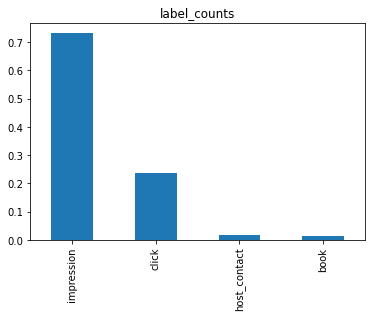

In [11]:
df.label.value_counts(normalize=True).plot.bar()
plt.title('label_counts')

## check that the labels are unique for user-listing pairs

In [7]:
df.groupby(['id_user','id_listing'])['label'].nunique().reset_index()['label'].max()

1

## Half the listings show up less than 3 times

count    30960.000000
mean         5.736047
std          8.246530
min          1.000000
25%          1.000000
50%          3.000000
75%          7.000000
max        235.000000
Name: 0, dtype: float64


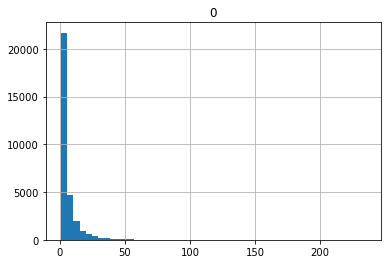

In [30]:
listing_counts = df.groupby(['id_listing']).size().reset_index()
print(listing_counts[0].describe())
listing_counts.hist(bins=50)
plt.show()

count    2999.000000
mean       59.215739
std        52.301913
min         1.000000
25%        25.000000
50%        45.000000
75%        77.000000
max       627.000000
Name: 0, dtype: float64


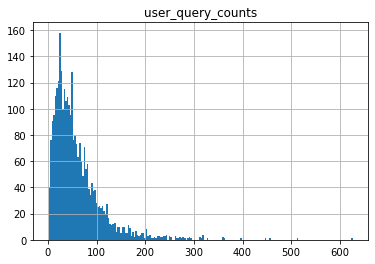

In [12]:
user_counts = df.groupby('id_user').size().reset_index()
print(user_counts[0].describe())
user_counts.hist(bins=200,)
plt.title("user_query_counts")
plt.show()

In [84]:
# More data suddenly on the last day
df.groupby('ds_search').size()

ds_search
2018-11-20    25608
2018-11-21    27548
2018-11-22    28374
2018-11-23    27344
2018-11-25    29007
2018-11-26    39707
dtype: int64

<AxesSubplot:xlabel='ds_search'>

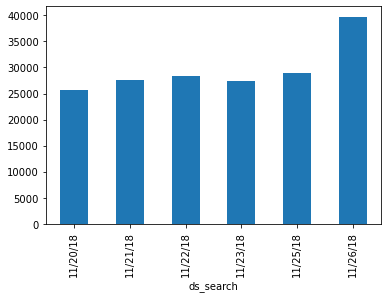

In [5]:
df.groupby('ds_search').size().plot.bar()

## Modeling Framework
### Baseline Model
- Using recommender framework to generate top listings
- Not a vanilla recommeder because the search parameters are probably more important to consider that user preferences
- Baseline would ignore search parameters to generate listings, and filter listings based distance and some logic requirements
- Generic baseline would be to use the most popular listing for a given search parameter within a distance max, and satisfying mininum number of nights criteria
- Using Collaborative filtering with implicit feedback without side information to generate baseline rankings

## Search parameter
- need to define a unique search
- I define a unique search with the same `['id_user','query_market','query_checkin','query_checkout',
'query_num_guests','query_num_children','query_num_infants']`
- this ignores lat/lon and price information

### Feedback rating
- using implicit feedback because impressions is very vague to guage level interest
- since I don't want to throw data away, I will accord a small positive value to impressions

### Train/test split criteria
- there's only 5 days, ordinarily I would create the training set on the first few days to evaluate on the last days
- the label info is already time muddled. if a label = `click` and some point earlier it was an impression, but we don't know when. 
- also we don't have enough data to do a cv routine using time ordered split.
- Another splitting criteria is to split the data randomly within subsets with the same search parameters
- I ended up using the time ordered set, and still needing to track recs for those with the same search parameters

In [8]:
# round some columns
listing_ratings = [col for col in df.columns  if col.endswith('rating')]
fees = ['listing_cleaning_fee','listing_monthly_price_factor','listing_weekly_price_factor']

df['query_radius'] = df['query_radius'].round(1)
df['listing_review_rating'] = df['listing_review_rating'].round(3)
df['listing_total_price'] = df['listing_total_price'].round()
df[listing_ratings] = df[listing_ratings].round(3)
df[fees] = df[fees].round(2)



In [9]:
# standarize the coordinates within listings
# Sometimes we see listings with different coordinates

listing_cords = df.groupby('id_listing')[['listing_lat','listing_lng']].mean().reset_index().round(2)
df = df.merge(listing_cords,on='id_listing',suffixes=['','_recentered'])

## Deal with missing values
- fill with the values with the same listing if possible



In [10]:
df['listing_maximum_nights_filled'] = df['listing_maximum_nights'].fillna(df.groupby('id_listing')['listing_maximum_nights'].transform('max'))
df['listing_minimum_nights_filled'] = df['listing_minimum_nights'].fillna(df.groupby('id_listing')['listing_minimum_nights'].transform('min'))
df['listing_maximum_nights_filled'].fillna(df['listing_maximum_nights_filled'].mode(),inplace=True)
df['listing_minimum_nights_filled'].fillna(df['listing_minimum_nights_filled'].mode(),inplace=True)


## Some queries have a range of coords within the same search.
- we need to rank searches by distance to query center
- if the center changes to much, we get too much noise
- about 462 queries where the centers too varied
- not enough for me worry.  
- We will just recenter coords within the same search

In [17]:
# standarize the query coordinates within the queries
# consider queries with the same values in these columns to be essentially the same
norm_cols = ['id_user','query_market','query_checkin','query_checkout','query_num_guests','query_num_children','query_num_infants']


In [19]:
hah = df.groupby(norm_cols)[['query_center_lat','query_center_lng']].std()
print(hah[(hah['query_center_lat'] >0.1) | (hah['query_center_lng'] >0.1)].shape)
hah.describe()

(462, 2)


,query_center_lat,query_center_lng
count,10601.000000,10601.000000
mean,0.034901,0.037505
std,0.505130,0.422082
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.016432,0.014142
max,31.072658,23.079965


In [44]:
norm_cols = ['id_user','query_market','query_checkin','query_checkout','query_num_guests','query_num_children','query_num_infants']
stand_cords = df.groupby(norm_cols)[['query_center_lat','query_center_lng']].mean().reset_index().round(2)
df = df.merge(stand_cords,on=norm_cols,suffixes=['','_recentered'])


In [21]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r


df['query_listing_dist'] = df.apply(lambda x: haversine(x['query_center_lng'],x['query_center_lat'],x['listing_lng'],x['listing_lat']),axis=1)

df.groupby('label')['query_listing_dist'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
book,2240.0,2.866652,5.859102,0.0,1.019259,1.111949,3.022619,152.449267
click,42251.0,4.891117,17.877426,0.0,1.023706,1.511399,4.564170,884.995846
host_contact,3066.0,4.469824,18.705401,0.0,1.019259,1.111949,3.335848,487.997196
impression,130031.0,9.675113,123.205017,0.0,1.023631,1.511348,4.245014,8243.163183


## We see that boookings are usually within 3km of the queries center

In [70]:
haversine(-43.18,-22.80,-43.28,-22.80)

10.250650356344197

## Ratings are implicit
click does indicates some interest could be positive or even negative
- impressions are ambigious, so we accord them a small positive value

In [22]:
# add numerical ratings
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
ratings_dict = {'impression':0.5,'click':2,'book':3,'host_contact':4}
df['rating'] = df['label'].apply(lambda x: ratings_dict[x])

scaler = MaxAbsScaler()
df['rating_scaled'] = scaler.fit_transform(df['rating'].values.reshape(-1, 1))

In [23]:
df.groupby('label')['listing_review_rating'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
book,1948.0,4.018105,1.758151,0.0,4.5,4.787,4.938,5.0
click,36959.0,3.492071,2.106772,0.0,0.0,4.714,4.929,5.0
host_contact,2730.0,3.304459,2.194655,0.0,0.0,4.667,4.934,5.0
impression,114569.0,3.399103,2.168186,0.0,0.0,4.723,4.939,5.0


## booked listings tend to have slighlty better ratings

In [24]:
time_cols = ['ds_search','query_checkin','query_checkout','ds_contact','ds_book']
for a in time_cols:
    df[a]= pd.to_datetime(df[a])
df['num_query_nights'] = (df.query_checkout-df.query_checkin).dt.days

In [25]:
def foo(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan
# columns can dedup because the number of listings are relatively low

prop_fill = df.groupby('id_listing')[['listing_minimum_nights_filled','listing_maximum_nights_filled']].agg(foo).reset_index()
df = df.drop(columns=['listing_minimum_nights_filled','listing_maximum_nights_filled']).merge(prop_fill,on=['id_listing'])

In [28]:
# create listing df with profile
listing_profile_cols = ['id_listing','listing_lat_recentered','listing_lng_recentered','listing_minimum_nights_filled','listing_maximum_nights_filled']
listing_df = df[listing_profile_cols].drop_duplicates()
listing_df

,id_listing,listing_lat_recentered,listing_lng_recentered,listing_minimum_nights_filled,listing_maximum_nights_filled
0,6f6d6ba9c29e63a1fdb85742a598b5b5,-22.98,-43.20,1.0,1125.0
34,15eaa0a653431dfb2c80e3e031866e49,-22.98,-43.20,2.0,30.0
50,69a48538dedb0975b59feaa6ba38567a,-22.98,-43.19,1.0,1120.0
135,79b9a8296d922ad4ebbd44c511049b90,-22.98,-43.19,4.0,6.0
146,cc68e4db29988e237131d93e022d7316,-22.98,-43.19,3.0,1125.0
...,...,...,...,...,...
177583,3a959f7609b79bfb3125417a4ab334e7,-23.60,-46.60,8.0,8.0
177584,89fa024ddee96ec79ebc0c085b063ef7,-23.57,-46.69,5.0,1125.0
177585,7a6677bc0b4cb38b4a8e72dc04f2cdca,-23.61,-46.69,5.0,365.0
177586,8faf943813216274f392027cbb809d8b,-22.66,-53.09,0.0,31.0


## create train/test split

In [54]:

before = df.query("ds_search not in ['2018-11-26']")
after = df.query("ds_search in ['2018-11-26']")
users_both = after.merge(before, on =['id_user'])['id_user'].unique()
# test = after[after['id_user'].isin(users_both)]

# train = pd.concat([before,after[~after['id_user'].isin(users_both)]])

before.shape,after.shape

((137881, 58), (39707, 58))

In [46]:
# another way to do splits
# split within queries of the same type
first_part = df.groupby(norm_cols).sample(frac=0.8, random_state=2)
second_part = df.drop(first_part.index)

first_part.shape,second_part.shape

((143342, 58), (34246, 58))

In [48]:
grouped_df = before.groupby(['id_user', 'id_listing']).sum().reset_index()

users = list(np.sort(grouped_df.id_user.unique())) # Get our unique customers
listings= list(grouped_df.id_listing.unique()) # Get our unique products that were purchased
rating = list(grouped_df.rating_scaled) # All of our purchases

train_user_cat = grouped_df.id_user.astype('category')
train_item_cat = grouped_df.id_listing.astype('category')

rows_train= train_user_cat.cat.codes 
# Get the associated row indices
cols_train = train_item_cat.astype('category').cat.codes 
# Get the associated column indices
ratings_sparse_train = sparse.csr_matrix((rating, (cols_train,rows_train)), shape=(len(listings), len(users)))

In [49]:
# Have a look at the sparsity
matrix_size = ratings_sparse_train.shape[0]*ratings_sparse_train.shape[1] # Number of possible interactions in the matrix
num_purchases = len(ratings_sparse_train.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.82225686085118

## Model training
- Don't worry about hyperparameter tuning for now
- use the implicit library for training a colloborative filtering model
- https://implicit.readthedocs.io/en/latest/quickstart.html

In [50]:
model = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=100,
                                             calculate_training_loss=True,random_state=32231)
alpha = 10
data = (ratings_sparse_train * alpha).astype('double')

# Fit the model
model.fit(data)

  0%|          | 0/100 [00:00<?, ?it/s]

## Test harness 
- get the recommendations for users in the test group
- restrict the after group to those with users in the before group
- compare the recall, precision,hit at n for searches with the same parameters
- remove listings that are too far
- remove listings that don't qualify on the nights criteria

In [55]:
test_searches = after[after['id_user'].isin(users_both)].groupby(norm_cols+['query_center_lat_recentered','query_center_lng_recentered',
                                               'num_query_nights'])['id_listing'].apply(list).reset_index()\
                                        .rename(columns={'id_listing':'listing_searched'})
unique_test_users = test_searches[['id_user']].drop_duplicates()
user_items = ratings_sparse_train.T.tocsr()
listing_df_ix = listing_df.set_index('id_listing')

In [59]:
# Recommendations
def get_rec_items(x,k=200):
    user_id = train_user_cat.cat.categories.get_loc(x['id_user'])
    item_ix = model.recommend(user_id, user_items,k)
    return [(train_item_cat.cat.categories[a[0]],a[1]) for a in item_ix]

unique_test_users['predicted'] = unique_test_users.apply(get_rec_items,axis=1)
test_searches_preds = test_searches.merge(unique_test_users,on=['id_user'])
test_searches_preds.head()

,id_user,query_market,query_checkin,query_checkout,query_num_guests,query_num_children,query_num_infants,query_center_lat_recentered,query_center_lng_recentered,num_query_nights,listing_searched,predicted
0,0088b42325fa2906faf06cb7bfcef953,City A,2018-12-20,2018-12-25,1,0,0,-22.91,-43.17,5,"[1e7e8b135d530d23d628dd5abe00ddbd, 46212082e50...","[(b4154bcfa234f3fd4482bcf68953646f, 0.14548717..."
1,0088b42325fa2906faf06cb7bfcef953,City A,2018-12-20,2018-12-25,2,0,0,-22.98,-43.19,5,"[69a48538dedb0975b59feaa6ba38567a, 038575944e3...","[(b4154bcfa234f3fd4482bcf68953646f, 0.14548717..."
2,0088b42325fa2906faf06cb7bfcef953,City A,2018-12-20,2018-12-25,3,1,1,-22.98,-43.19,5,[a175606dd7c00bcc9f86046048c799a4],"[(b4154bcfa234f3fd4482bcf68953646f, 0.14548717..."
3,0088b42325fa2906faf06cb7bfcef953,City A,2018-12-20,2019-06-25,2,0,0,-22.92,-43.19,187,"[262bf44fafb93037531774c7c7cb68b1, 07287d675d3...","[(b4154bcfa234f3fd4482bcf68953646f, 0.14548717..."
4,0088b42325fa2906faf06cb7bfcef953,City A,2019-06-20,2019-06-25,2,0,0,-22.92,-43.19,5,"[ad62e0a3f8e5e6725b9a108de57ec726, 082ec0bf6b5...","[(b4154bcfa234f3fd4482bcf68953646f, 0.14548717..."


## Filter recommedations to fulfill mininum and maximum nights criteria 
- remove listings more than 10km from the query center


In [61]:
def filter_recs(x,radius=10):
    return [a for a in x['predicted'] if ((listing_df_ix.loc[a[0]]['listing_minimum_nights_filled'] <= x['num_query_nights']) & 
           (listing_df_ix.loc[a[0]]['listing_maximum_nights_filled'] >= x['num_query_nights']) &
           (haversine(x['query_center_lng_recentered'],x['query_center_lat_recentered'],
                           listing_df_ix.loc[a[0]]['listing_lng_recentered'],listing_df_ix.loc[a[0]]['listing_lat_recentered']) < radius))]
  
test_searches_preds['filtered_recs'] = test_searches_preds.apply(filter_recs,axis=1)
test_searches_preds['recs'] =test_searches_preds['filtered_recs'].apply(lambda x: [a[0] for a in x])

In [63]:
def precision_recall_at_k(predictions,pred_col='recs', k=10):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    precision=0
    recall = 0
    hit = 0
    tot_users = len(predictions)
    for _,x in predictions.iterrows():
        n_prec = sum( a in x['listing_searched'] for a in x[pred_col][:k] )
        n_rec = sum( a in x[pred_col][:k] for a in x['listing_searched'])
        
        precision += n_prec/k if len(x[pred_col]) > 0 else 0
        hit += int(n_prec>0)
        recall += n_rec /len(x['listing_searched']) if len(x[pred_col]) >0 else 0
    print('precision:',precision/tot_users,'recall:',recall/tot_users,'hit_rate:',hit/tot_users)


precision_recall_at_k(test_searches_preds, k=10)

precision: 0.02559446606139225 recall: 0.027324359854043224 hit_rate: 0.17163856463467358


In [226]:
rand_recs = np.random.choice(listings,size=(2313,10))
test_searches_preds['random_recs']= test_searches_preds.apply(lambda x: rand_recs[x.name],axis=1)
precision_recall_at_k(test_searches_preds,'random_recs', k=10)

precision: 0.00025940337224383917 recall: 0.00012926502107483411 hit_rate: 0.0025940337224383916


## Promising, baseline Model with minimal tuning
- the hit rate shows, 17% of queries had some overlap with recommendations
- results are better than a random policy
- this is only for users that in both training and test set
- low precision and recall of about 2.5%
- let's see if a more sophisticated model does better

# Main Model
- We need to take into account user context and also side information from listings
- We will use a deep learning model that uses the user embeddings, search parameter embeddings together with item embeddings to predict ratings
- the query model handles user and search parameters
- the candidate model handles the item embeddings with item features
- model based on this https://www.tensorflow.org/recommenders/examples/multitask

In [64]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict, Text

## create a listing profile
- some listings have multiple values for particular columns that are problematic e.g listings with multiple listing_num_bedrooms
- we need to standardize multiple entries to create a listing profile
- room_type, property type, we use the most common values
- price is increasting to explore. we only have total price not the unique price per night
- we see booked listings have lower prices on average
- but it's hard to incorporate price information for features because listings can have multiple prices which further spar



In [89]:
df['price_night'] = df['listing_total_price'].div(df['num_query_nights']).round()
df.groupby('label')['price_night'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
book,2138.0,71.409261,79.450213,0.0,29.0,48.0,79.0,891.0
click,40083.0,90.579697,177.570416,0.0,32.0,53.0,96.0,10074.0
host_contact,2914.0,101.111874,162.808773,0.0,34.0,58.0,118.0,5734.0
impression,123432.0,124.994880,1521.742103,0.0,34.0,59.0,117.0,525996.0


## create price median feature for item
- idea being that some listings are more expensive that others.

In [111]:
df['price_median'] = df.merge(df.groupby('id_listing')['price_night'].median().reset_index().rename(columns={'price_night':'price_median'})
         ,on=['id_listing'])['price_median'].fillna(-2)

In [112]:
## Standardize item features
item_features = ['id_listing','listing_is_new','listing_num_bedrooms',
                 'listing_lat_recentered','listing_lng_recentered','price_median',
                 'listing_property_type','listing_room_type','listing_review_count',
                 'listing_review_rating','listing_num_beds','listing_minimum_nights','listing_maximum_nights']

user_features = ['id_user','query_market','query_num_guests','query_num_infants','query_num_children',
                 'query_price_max','query_center_lat_recentered','query_center_lng_recentered',
                 'num_query_nights','query_includes_weekend','contact_ratio']

In [113]:
# Deal with nulls
df2 =df.copy()
df2['listing_review_rating'] = df2['listing_review_rating'].round(2)
df2['listing_is_new']

df2['listing_num_bedrooms'] = df2['listing_num_bedrooms'].fillna(df.groupby('id_listing')['listing_num_bedrooms'].transform('min'))
df2['listing_num_beds'] = df2['listing_num_beds'].fillna(df.groupby('id_listing')['listing_num_beds'].transform('min'))


df2['listing_review_count'].fillna(-2,inplace=True) # use unknown token
df2['listing_review_rating'].fillna(-2,inplace=True) # unknown token
df2['listing_property_type'].fillna(-2,inplace=True)
df2['listing_num_beds'].fillna(2,inplace=True)  # use the median
df2['listing_num_bedrooms'].fillna(1,inplace=True) #use the median
df2['listing_minimum_nights'].fillna(1,inplace=True) #use the median
df2['listing_maximum_nights'].fillna(1000,inplace=True) #use the median

In [92]:
df2[item_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177588 entries, 0 to 177587
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id_listing              177588 non-null  object 
 1   listing_is_new          177588 non-null  int64  
 2   listing_num_bedrooms    177588 non-null  float64
 3   listing_lat_recentered  177588 non-null  float64
 4   listing_lng_recentered  177588 non-null  float64
 5   listing_property_type   177588 non-null  float64
 6   listing_room_type       177588 non-null  object 
 7   listing_review_count    177588 non-null  float64
 8   listing_review_rating   177588 non-null  float64
 9   listing_num_beds        177588 non-null  float64
 10  listing_minimum_nights  177588 non-null  float64
 11  listing_maximum_nights  177588 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 21.6+ MB


In [93]:
# check item features with multiple entries per column

for a in item_features[1:]:
    hmm =df.groupby('id_listing')[a].nunique().reset_index()
    print(a,"uniques:", df.groupby('id_listing')[a].nunique().max(),"num > 1:",len(hmm[hmm[a]>1]))

listing_is_new uniques: 2 num > 1: 318
listing_num_bedrooms uniques: 3 num > 1: 44
listing_lat_recentered uniques: 1 num > 1: 0
listing_lng_recentered uniques: 1 num > 1: 0
listing_property_type uniques: 2 num > 1: 40
listing_room_type uniques: 2 num > 1: 13
listing_review_count uniques: 4 num > 1: 3495
listing_review_rating uniques: 5 num > 1: 2646
listing_num_beds uniques: 4 num > 1: 5768
listing_minimum_nights uniques: 5 num > 1: 6148
listing_maximum_nights uniques: 3 num > 1: 85


In [ ]:
### More feature engineering
# time features
df2['time_search_checkin_diff'] = (df2['query_checkin'] - df2['ds_search']).dt.days

df2['query_checkin_dayname'] = pd.DatetimeIndex(df2['query_checkin']).day_name()
df2['query_checkout_dayname'] = pd.DatetimeIndex(df2['query_checkout']).day_name()

days= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

def include_weekend(day_1,day_2,num_days):
    if (days.index(day_1) in days[5:]) or (days.index(day_2) in days[5:]):
        return 1
    elif (days.index(day_2)<days.index(day_1)):
        return 1
    else:
        return 0
    
df2['query_includes_weekend'] = df2.apply(lambda x: include_weekend(x['query_checkin_dayname'],
                                                                  x['query_checkout_dayname'],
                                                                  x['num_query_nights']),axis=1 )

## Create contact ratio user feature
- compare contacts to searches
- the idea for users is that some people like clicking without really intending while others are more straightforward

In [114]:
df2['ds_contact_null'] = (~df2['ds_contact'].isnull()).astype(int)
contact_ratio = df2.groupby('id_user').agg(count_search=('id_search', 'count'), num_bookings=('ds_contact_null', 'sum')).reset_index()
contact_ratio['contact_ratio'] = contact_ratio['num_bookings'].div(contact_ratio['count_search']).round(2)
df3 = df2.merge(contact_ratio.drop(columns=['count_search','num_bookings']))

In [115]:
# Create the unique users and listings df
users_df = df3[user_features].drop_duplicates()
listings_df = df3[item_features].drop_duplicates()


In [116]:
# Create holdout set
# first_part_dp = df3.groupby(norm_cols).sample(frac=0.8, random_state=2131)
# second_part_dp = df3.drop(first_part_dp.index)

first_part_dp = df3.loc[before.index]
second_part_dp = df3.drop(first_part_dp.index)

first_part_dp.shape,second_part_dp.shape

((137881, 66), (39707, 66))

In [117]:
users_tf = tf.data.Dataset.from_tensor_slices(dict(users_df))
listings_tf = tf.data.Dataset.from_tensor_slices(dict(listings_df))
first_part_tf = tf.data.Dataset.from_tensor_slices(dict(first_part_dp[user_features+item_features+['rating']]))
listings_df.reset_index(inplace=True)

## Cleaning up the features before feeding the model

In [118]:
# user query features

unique_query_market = df3['query_market'].unique().tolist()

# listings_tf = user_listing.map(lambda x:x['id_listing'])
# users_tf = user_listing.map(lambda x:x['id_user'])

unique_listings = df3['id_listing'].drop_duplicates().to_numpy()
unique_user_ids = df3['id_user'].drop_duplicates().to_numpy()


col="query_price_max"
max_num = df3[col].max()
min_num = df3[col].min()
out_num =  df3[col].quantile(0.95)
query_price_max = df3[col].to_numpy()
# query_price_max_buckets = np.hstack([-1, np.linspace(0, max_num, num=50).round(2)])
query_price_max_buckets = np.hstack([-1,np.linspace(0, out_num, num=50).round(2),max_num])



col="query_radius"
max_num = df3[col].max()
min_num = df3[col].min()
out_num =  df3[col].quantile(0.95)
query_radius = df3[col].to_numpy()
query_radius_buckets = np.hstack([np.linspace(0, out_num, num=50).round(2),max_num])



col="time_search_checkin_diff"
max_num = df3[col].max()
min_num = df3[col].min()
out_num =  df3[col].quantile(0.95)
time_search_checkin_diff = df3[col].to_numpy()
time_search_checkin_diff_buckets = np.hstack([-1,np.linspace(0, out_num, num=50).round(2),max_num])

num_query_nights = df3['num_query_nights'].to_numpy()
query_num_children = df3['query_num_children'].to_numpy()
query_num_infants = df3['query_num_infants'].to_numpy()
query_num_guests = df3['query_num_guests'].to_numpy()
query_center_lat = df3['query_center_lat'].to_numpy()
query_center_lng = df3['query_center_lng'].to_numpy()
query_center_lat_recentered = df3['query_center_lat_recentered'].to_numpy()
query_center_lng_recentered = df3['query_center_lng_recentered'].to_numpy()
query_includes_weekend = df3['query_includes_weekend'].to_numpy()
contact_ratio = df3['contact_ratio'].to_numpy()


# item query features

unique_listing_property_type = df3['listing_property_type'].unique().tolist()
unique_listing_room_type = df3['listing_room_type'].unique().tolist()
unique_listing_has_pro_pictures = df3['listing_has_pro_pictures'].unique().tolist()
unique_listing_is_new = df3['listing_is_new'].unique().tolist()


listing_review_rating_buckets = np.hstack([-2,np.linspace(0, 5, num=50).round(2)])

col="listing_review_count"
max_num = df3[col].max()
min_num = df3[col].min()
out_num =  df3[col].quantile(0.95)
listing_review_count = df3[col].to_numpy()
listing_review_count_buckets = np.hstack([-2,np.linspace(0, out_num, num=30).round(2),max_num])

col="price_median"
max_num = df3[col].max()
min_num = df3[col].min()
out_num =  df3[col].quantile(0.95)
price_median = df3[col].to_numpy()
price_median_buckets = np.hstack([-2,np.linspace(0, out_num, num=30).round(2),max_num])




listing_review_rating = df3['listing_review_rating'].to_numpy()
listing_num_beds = df3['listing_num_beds'].to_numpy()
listing_num_bedrooms = df3['listing_num_bedrooms'].to_numpy()
listing_lat_recentered = df3['listing_lat_recentered'].to_numpy()
listing_lng_recentered = df3['listing_lng_recentered'].to_numpy()
listing_minimum_nights = df3['listing_minimum_nights'].to_numpy()
listing_maximum_nights = df3['listing_maximum_nights'].to_numpy()

In [119]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self._embeddings = {}
        self.embedding_dimension = 32
        self._embed_features = ['id_user','query_market','query_price_max']
        self.norm_features = ['num_query_nights','query_num_children','query_num_infants',
                              'query_includes_weekend','query_num_guests','query_center_lng_recentered'
                              ,'query_center_lat_recentered','contact_ratio']
        
        self.norm_features = ['num_query_nights','query_num_children','query_num_infants',
                              'query_includes_weekend','query_num_guests','contact_ratio']
        self.vocabularies_norm = {a:globals()[a] for a in self.norm_features}

        self.vocabularies = {'id_user':unique_user_ids,
                             'query_market':unique_query_market,
                            'query_price_max':query_price_max_buckets,
                             'query_radius':query_radius_buckets,
                             'time_search_checkin_diff':time_search_checkin_diff_buckets,
                            }

        for feature_name in ['id_user','query_market']:
            vocabulary = self.vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                  [tf.keras.layers.StringLookup(
                      vocabulary=vocabulary, mask_token=None),
                   tf.keras.layers.Embedding(len(vocabulary) + 1,
                                             self.embedding_dimension)
            ])

        for feature_name in ['query_price_max']:
            vocabulary = self.vocabularies[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential([
            tf.keras.layers.Discretization(vocabulary.tolist()),
            tf.keras.layers.Embedding(len(vocabulary) + 1, self.embedding_dimension),
        ])

        for feature_name in self.norm_features:
            a = tf.keras.layers.Normalization(axis=None)
            a.adapt(self.vocabularies_norm[feature_name])
            self._embeddings[feature_name] = a



    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        embeddings = []
        for feature_name in self._embed_features:
                embedding_fn = self._embeddings[feature_name]
                embeddings.append(embedding_fn(inputs[feature_name]))

        for feature_name in self.norm_features:
                embedding_fn = self._embeddings[feature_name]
                embeddings.append(tf.reshape(embedding_fn(inputs[feature_name]), (-1, 1)))

        x = tf.concat(embeddings, axis=1)
        return x

In [120]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # We first use the user model for generating embeddings.
    self.embedding_model = UserModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [140]:
class ListingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        max_tokens = 10_000

        self._embeddings = {}
        self.embedding_dimension = 32
        self._embed_features_str = ['id_listing','listing_room_type']
        self._embed_features_int = ['listing_property_type','listing_is_new']
        self._embed_features_disc = ['listing_review_count','listing_review_rating','price_median']
        self.norm_features = ['listing_lat_recentered','listing_lng_recentered','listing_minimum_nights',
                             'listing_maximum_nights','listing_num_beds','listing_num_bedrooms']
        
        
        self.vocabularies_unique = {'id_listing':unique_listings,
                             'listing_is_new':unique_listing_is_new,
                             'listing_property_type':unique_listing_property_type,
                             'listing_room_type':unique_listing_room_type}
        
        self.vocabularies_bucket = {'listing_review_count':listing_review_count_buckets,
                                    'listing_review_rating':listing_review_rating_buckets,
                                   'price_median':price_median_buckets}
        self.vocabularies_norm = {a:globals()[a] for a in self.norm_features}

        for feature_name in self._embed_features_str:
            vocabulary = self.vocabularies_unique[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                  [tf.keras.layers.StringLookup(
                      vocabulary=vocabulary, mask_token=None),
                   tf.keras.layers.Embedding(len(vocabulary) + 1,
                                             self.embedding_dimension)
            ])
            
        for feature_name in self._embed_features_int:
            vocabulary = self.vocabularies_unique[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential(
                  [tf.keras.layers.IntegerLookup(
                      vocabulary=vocabulary, mask_token=None),
                   tf.keras.layers.Embedding(len(vocabulary) + 1,
                                             self.embedding_dimension)
            ])
            
        for feature_name in self._embed_features_disc:
            vocabulary = self.vocabularies_bucket[feature_name]
            self._embeddings[feature_name] = tf.keras.Sequential([
            tf.keras.layers.Discretization(vocabulary.tolist()),
            tf.keras.layers.Embedding(len(vocabulary) + 1, self.embedding_dimension),
        ])

        for feature_name in self.norm_features:
            a = tf.keras.layers.Normalization(axis=None)
            a.adapt(self.vocabularies_norm[feature_name])
            self._embeddings[feature_name] = a
            

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        embeddings = []
        for feature_name in self._embed_features_str+self._embed_features_int+self._embed_features_disc:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(inputs[feature_name]))
            
        for feature_name in self.norm_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(tf.reshape(embedding_fn(inputs[feature_name]), (-1, 1)))

        x = tf.concat(embeddings, axis=1)
        return x


In [122]:
class CandidateModel(tf.keras.Model):
  """Model for encoding listing."""

  def __init__(self, layer_sizes):
    """Model for encoding movies.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    self.embedding_model = ListingModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

## The model uses combination of rating and retrieval metrics for training
- the retrieval metrics does not use ratings, it assumes all ratings are 1
- the ranking portion does the usual rmse squared on the numerical metrics
- I went for the mix because reducing rsme turns out to be a finicky job.

In [142]:
class FullerModel(tfrs.models.Model):

  def __init__(self, layer_sizes, rating_weight: float, retrieval_weight: float):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.retrieval_task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=listings_tf.batch(128).map(self.candidate_model),
        ),
    )

    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

 # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight
    

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

    query_embeddings = self.query_model({a:features[a] for a in user_features})
    candidate_embeddings = self.candidate_model({a:features[a] for a in item_features})

    return (
        query_embeddings,
        candidate_embeddings,
        self.rating_model(tf.concat([query_embeddings, candidate_embeddings], axis=1)),
        )
    

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    query_embeddings, candidate_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(query_embeddings, candidate_embeddings,compute_metrics = not training)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss

            + self.retrieval_weight * retrieval_loss)

In [127]:
# create validation data
shuffled = first_part_tf.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(107881)
test = shuffled.skip(107881).take(30_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

## Train Model

In [143]:

num_epochs = 50

model = FullerModel(layer_sizes=[32], rating_weight=0.2, retrieval_weight=0.8)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Epoch 1/50
53/53 [==============================] - 7s 78ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 0.8060 - loss: 13946.2691 - regularization_loss: 0.0000e+00 - total_loss: 13946.2691
Epoch 2/50
53/53 [==============================] - 5s 75ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 0.7779 - loss: 10220.4618 - regularization_loss: 0.0000e+00 - total_loss: 10220.4618
Epoch 3/50
53/53 [==============================] - 5s 78m

Epoch 16/50
53/53 [==============================] - 6s 80ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 0.7566 - loss: 4851.8397 - regularization_loss: 0.0000e+00 - total_loss: 4851.8397
Epoch 17/50
53/53 [==============================] - 6s 78ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 0.7520 - loss: 4760.5393 - regularization_loss: 0.0000e+00 - total_loss: 4760.5393
Epoch 18/50
53/53 [==============================] - 6s 82ms

Epoch 31/50
53/53 [==============================] - 6s 82ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 0.7365 - loss: 3952.0460 - regularization_loss: 0.0000e+00 - total_loss: 3952.0460
Epoch 32/50
53/53 [==============================] - 6s 80ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 0.7356 - loss: 3909.9466 - regularization_loss: 0.0000e+00 - total_loss: 3909.9466
Epoch 33/50
53/53 [==============================] - 6s 80ms

Epoch 46/50
53/53 [==============================] - 6s 80ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 0.7101 - loss: 3542.2074 - regularization_loss: 0.0000e+00 - total_loss: 3542.2074
Epoch 47/50
53/53 [==============================] - 6s 82ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 0.7077 - loss: 3518.1935 - regularization_loss: 0.0000e+00 - total_loss: 3518.1935
Epoch 48/50
53/53 [==============================] - 6s 81ms

In [144]:
model.evaluate(cached_test, return_dict=True)

8/8 [==============================] - 90s 11s/step - factorized_top_k/top_1_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0010 - factorized_top_k/top_10_categorical_accuracy: 0.0032 - factorized_top_k/top_50_categorical_accuracy: 0.0173 - factorized_top_k/top_100_categorical_accuracy: 0.0322 - root_mean_squared_error: 0.7759 - loss: 32522.2847 - regularization_loss: 0.0000e+00 - total_loss: 32522.2847


{'factorized_top_k/top_1_categorical_accuracy': 9.999999747378752e-05,
 'factorized_top_k/top_5_categorical_accuracy': 0.0010333333630114794,
 'factorized_top_k/top_10_categorical_accuracy': 0.0031666667200624943,
 'factorized_top_k/top_50_categorical_accuracy': 0.01730000041425228,
 'factorized_top_k/top_100_categorical_accuracy': 0.03220000118017197,
 'root_mean_squared_error': 0.7758715152740479,
 'loss': 10683.1171875,
 'regularization_loss': 0,
 'total_loss': 10683.1171875}

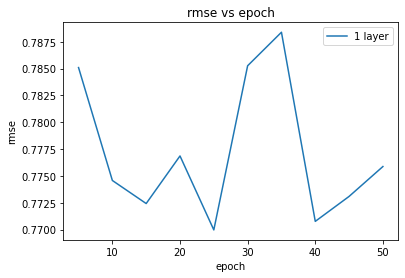

In [145]:
num_validation_runs = len(one_layer_history.history["val_root_mean_squared_error"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["val_root_mean_squared_error"], label="1 layer")
# plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("rmse vs epoch")
plt.xlabel("epoch")
plt.ylabel("rmse");
plt.legend()

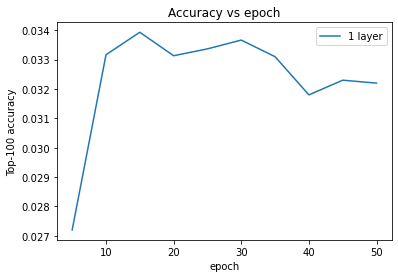

In [146]:
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
# plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()



In [679]:
# update model with test data
model.fit(cached_test)

8/8 [==============================] - 1s 108ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 0.7596 - loss: 21009.1521 - regularization_loss: 0.0000e+00 - total_loss: 21009.1521


### Evaluate the holdout set

In [163]:
second_part_dp_mod = second_part_dp.copy()
second_part_dp_mod['query_price_max'] = -1   #zeror out this parameter to be able to compare with baseline

test_searches_dp = second_part_dp_mod.groupby(user_features+['query_checkin','query_checkout'])['id_listing'].apply(list).reset_index()\
                                        .rename(columns={'id_listing':'listing_searched'})
test_searches_dp_tf = tf.data.Dataset.from_tensor_slices(dict(test_searches_dp[user_features]))


## Generate recommendations
- get user and item embedding, take the dot product and sort to get the top k
- the top k does not have a unique item list because items will have different ratings depending on the item side information
- we have to merge the recs to get a unique item list


In [184]:
k= 10

In [165]:
user_emb= np.vstack(list(test_searches_dp_tf.batch(100).map(model.query_model).as_numpy_iterator()))
user_emb = user_emb / np.linalg.norm(user_emb, axis = 1).reshape((-1, 1))

listing_emb = np.vstack(list(listings_tf.batch(100).map(model.candidate_model).as_numpy_iterator()))
listing_emb = listing_emb / np.linalg.norm(listing_emb, axis = 1).reshape((-1, 1))

index_tf = user_emb.dot(listing_emb.T)
rec_orders = np.argsort(index_tf,axis=1)


test_searches_dp['predicted'] = test_searches_dp.apply(lambda x: list(OrderedDict.fromkeys(listings_df.loc[rec_orders[x.name][::-1][:100]]['id_listing'].tolist())),axis=1)
precision_recall_at_k(test_searches_dp,'predicted', k=10)

precision: 0.0039691714836223545 recall: 0.006413688929980476 hit_rate: 0.03641618497109827


In [166]:
def filter_recs(x,radius=10):
    return [a for a in x['predicted'] if ((listing_df_ix.loc[a]['listing_minimum_nights_filled'] <= x['num_query_nights']) & 
           (listing_df_ix.loc[a]['listing_maximum_nights_filled'] >= x['num_query_nights']) &
           (haversine(x['query_center_lng_recentered'],x['query_center_lat_recentered'],
                           listing_df_ix.loc[a]['listing_lng_recentered'],listing_df_ix.loc[a]['listing_lat_recentered']) < radius))]
  


test_searches_dp['filtered_recs'] = test_searches_dp.apply(filter_recs,axis=1)

In [167]:
# metrics if we do some post filtering
precision_recall_at_k(test_searches_dp,'filtered_recs', k=10)

precision: 0.005163776493256279 recall: 0.009311398955099056 hit_rate: 0.046242774566473986


In [201]:
# metrics only for users in the both train and test
precision_recall_at_k(test_searches_dp[test_searches_dp['id_user'].isin(users_both)],'filtered_recs', k=10)

precision: 0.004727272727272722 recall: 0.007747731577971569 hit_rate: 0.041212121212121214


In [223]:
rand_recs = np.random.choice(unique_listings,size=(5190,10))
test_searches_dp['random_recs']= test_searches_dp.apply(lambda x: rand_recs[x.name],axis=1)
precision_recall_at_k(test_searches_dp,'random_recs', k=10)

precision: 0.00025048169556840077 recall: 0.0006502444211140015 hit_rate: 0.0025048169556840076


## The model is worse compared to baseline
- without postfiltering the hit rate about 3.6%
- filtering makes the results makes the make metrics better, which makes me think about the fraction of the recs that would be logically consistent with query
- thankfully the model is an order of magnitude better than the random policy
- normalizing queries is an issue to be able to compare with baseline. the baseline gets rid of some parameters, notably the `query_price_max`. For the model, I had to zero out this parameter
- the baseline can only generate recs for people in the training set, whereas, this model can generate recs for unseen users

### hyperameter tuning would be a finicky job
- not going to fuss with it for now

### Generating recommendations with new listings
- given the low hit rate of the model, the model generates a lot of seredipitous recommendations that are labeled `new`.
- we can check the fraction of recs that are new.
- Moreover, there are items in the test set that were not seen during training
- we can still generate embeddings for these items. So there are recs for these items as wells

In [181]:
unseen_items = list(set(after.id_listing.unique().tolist()).difference(set(before.id_listing.unique().tolist())))

In [185]:
test_searches_dp['top_n'] = test_searches_dp['filtered_recs'].apply(lambda x: x[:k])
exploded = test_searches_dp.explode('top_n')
exploded['new_item'] = exploded['top_n'].apply(lambda x: int(x in unseen_items))

In [195]:
exploded.groupby(norm_cols)['new_item'].mean().reset_index()['new_item'].describe()

count    5190.000000
mean        0.039306
std         0.095079
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: new_item, dtype: float64

In [196]:
exploded.groupby(norm_cols)['new_item'].mean().reset_index()['new_item'].quantile(0.9)

0.1

## about 10% of the ranked lists include unseen items
- For listings completely unknown to the searches, we can generate an embedding based on the new listing parameters
- recommend the new listings based on nearest neighbor searches in the item-item space 
- Perhaps require a threshold frac of new listings per recs

# Summary
- Created a Colloborative filtererings model with post filters for the baseline model
- examined precision/recall and hit rate
- Created a deep recommender to handle context information. A combination loss of rmse and topkrankings was used to train
- results were not great for the deep learning model.  
- Hyperparameter tuning is greatly needed
- perhaps use binary-cross-entropy loss instead of rmse.